# Results for GDF+PCA+LSTM

Here we present results for the best LSTMs choosen based on best MCC (matthews) score on validation set. 
The features for LSTMs are GDFs reduced by PCA (number of components is chosen based on sum of explained variance ratio > 0.99).

Because LSTMs are not deterministic, the scores may vary, so we calculated scores 30 times for each model. Next we took mean obtained scores, so we can compare with scores obtained for Logistic Regression on Queue Imbalance feature (QUE+LOG).

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gru_iter/'
if_should_savefig = True #Change plot names

## Data 

Columns with suffix `gru` are scores obtained using GDF+PCA+GRU.

Columns with suffix `log` are scores obtained using QUE+LOG.

Columns with *prefix* `diff` are differences of scores between GRUs - LOGs.

`r`, `s` - parameters for GDF (s - sigma, r - scale).

In [3]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    d = pd.read_csv(os.path.join(data_dir, f))
    df_res = df_res.append(d)
    print(f, len(d))
df_log = pd.read_csv('res_log_que.csv')    

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).mean()
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_lstm', '_log'])
df_best.index = df_best['stock']

res_gru_iter_4320_len24000_r0.1_s0.1.csv_partial 30
res_gru_iter_11583_len24000_r0.01_s0.1.csv 30
res_gru_iter_9061_len24000_r0.25_s0.25.csv 30
res_gru_iter_2748_len24000_r0.01_s0.1.csv 30
res_gru_iter_2822_len24000_r0.01_s0.1.csv 30
res_gru_iter_4851_len24000_r0.01_s0.1.csv_partial 30
res_gru_iter_3459_len24000_r0.1_s0.1.csv 30
res_gru_iter_10470_len24000_r0.01_s0.1.csv 30
res_gru_iter_4851_len24000_r0.01_s0.1.csv 30
res_gru_iter_2822_len24000_r0.01_s0.1.csv_partial 30
res_gru_iter_3879_len24000_r0.01_s0.1.csv_partial 30
res_gru_iter_1431_len24000_r0.25_s0.25.csv 30
res_gru_iter_3459_len24000_r0.1_s0.1.csv_partial 30
res_gru_iter_2730_len24000_r0.25_s0.25.csv 30
res_gru_iter_9062_len24000_r0.01_s0.1.csv_partial 30
res_gru_iter_10470_len24000_r0.01_s0.1.csv_partial 30
res_gru_iter_4799_len24000_r0.25_s0.25.csv 30
res_gru_iter_4799_len24000_r0.25_s0.25.csv_partial 30
res_gru_iter_2748_len24000_r0.01_s0.1.csv_partial 30
res_gru_iter_9058_len24000_r0.25_s0.25.csv 30
res_gru_iter_1431_len2

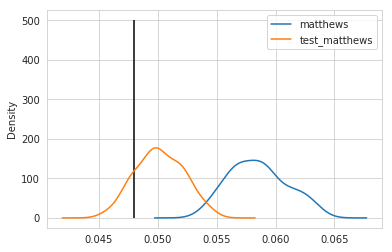

In [4]:
stock = 9062
df_res[df_res['stock'] == stock][['matthews', 'test_matthews']].plot(kind='kde')
a = df_log[df_log['stock'] == stock]['test_matthews'].values[0]
plt.vlines(a, ymin=0, ymax=500)

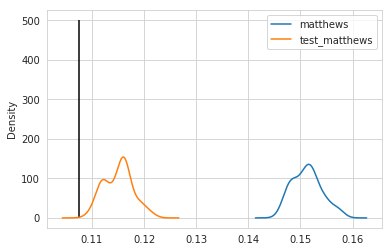

In [5]:
stock = 9761
df_res[df_res['stock'] == stock][['matthews', 'test_matthews']].plot(kind='kde')
a = df_log[df_log['stock'] == stock]['test_matthews'].values[0]
plt.vlines(a, ymin=0, ymax=500)

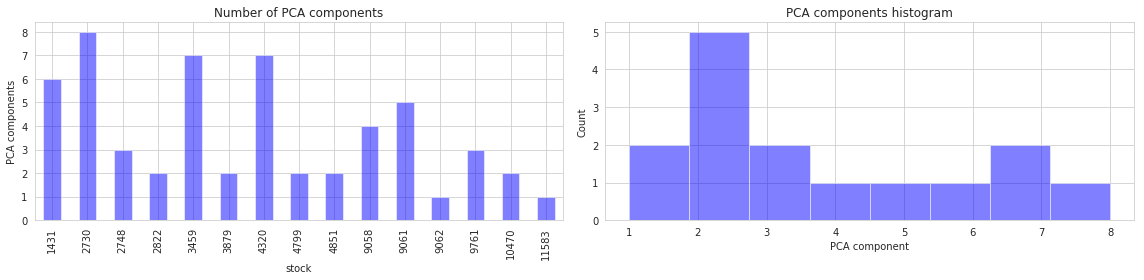

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best['pca_components'].plot(kind='bar', color=['b'], alpha=0.5, ax=ax1)
ax1.set_title('Number of PCA components')
ax1.set_ylabel('PCA components')

# sns.distplot(df_best['pca_components'], ax=ax2, bins=10, kde=False)
df_best['pca_components'].hist(color='b', alpha=0.5, bins=8)
ax2.set_title('PCA components histogram')
ax2.set_ylabel('Count')
ax2.set_xlabel('PCA component')


plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_pca_components.png')

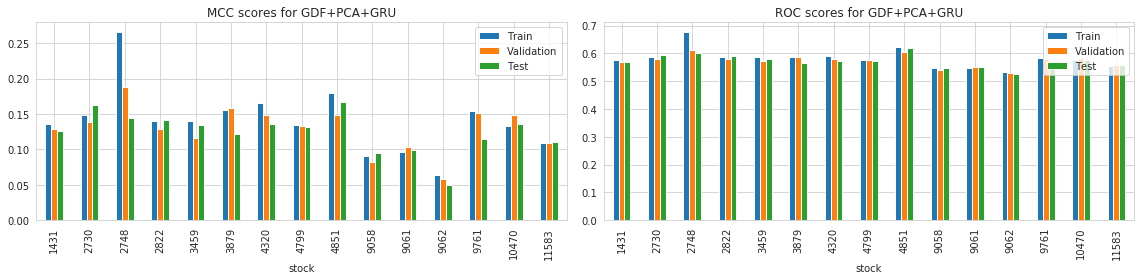

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm']].plot(kind='bar', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])

ax1.set_title('MCC scores for GDF+PCA+GRU')

df_best[['train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].plot(kind='bar', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])

ax2.set_title('ROC scores for GDF+PCA+GRU')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_mcc_roc_bar.png')

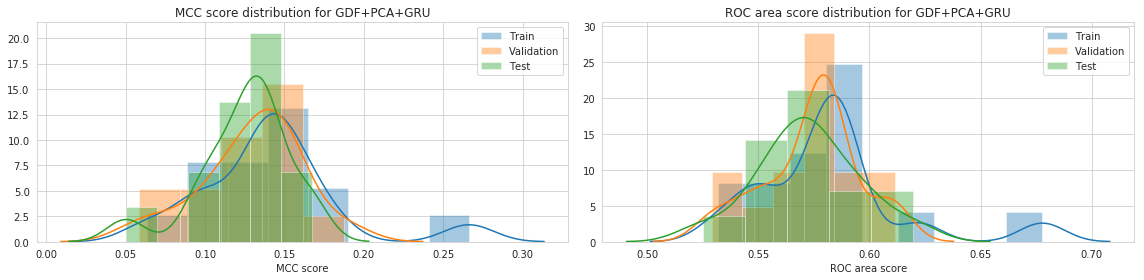

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_lstm'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_lstm'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_lstm'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+GRU')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_lstm'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_lstm'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_lstm'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+GRU')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_score_dist.png')

In [9]:
df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm', 
        'train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].describe()

,train_matthews_lstm,matthews_lstm,test_matthews_lstm,train_roc_auc_lstm,roc_auc_lstm,test_roc_auc_lstm
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.140834,0.129516,0.124911,0.582206,0.574047,0.572531
std,0.046199,0.032159,0.028992,0.034428,0.022109,0.023380
min,0.063412,0.058509,0.050159,0.531857,0.529132,0.525227
25%,0.120656,0.112841,0.112725,0.565715,0.563576,0.560017
50%,0.139917,0.133453,0.131989,0.584202,0.580344,0.573492
75%,0.155196,0.148953,0.139109,0.587919,0.582752,0.585171
max,0.266273,0.187762,0.167083,0.677755,0.611680,0.619784


In [21]:
print(df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm', 
        'train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews\_lstm &  matthews\_lstm &  test\_matthews\_lstm &  train\_roc\_auc\_lstm &  roc\_auc\_lstm &  test\_roc\_auc\_lstm \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &             0.140834 &       0.129516 &            0.124911 &            0.582206 &      0.574047 &           0.572531 \\
std   &             0.046199 &       0.032159 &            0.028992 &            0.034428 &      0.022109 &           0.023380 \\
min   &             0.063412 &       0.058509 &            0.050159 &            0.531857 &      0.529132 &           0.525227 \\
25\%   &             0.120656 &       0.112841 &            0.112725 &            0.565715 &      0.563576 &           0.560017 \\
50\%   &             0.139917 &       0.133453 &            0.131989 &            0.584202 &      0.580344 &           0.573492 \\
75\%   &             0.155196 &    

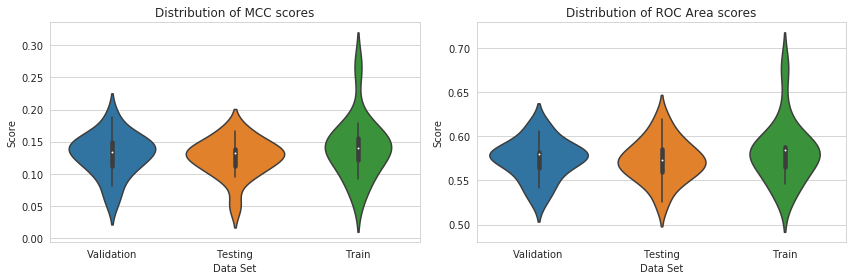

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_lstm', 'roc_auc_lstm', 
           'test_matthews_lstm', 'test_roc_auc_lstm', 'train_matthews_lstm', 'train_roc_auc_lstm']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_lstm': 'Validation', 'test_matthews_lstm': 'Testing', 'train_matthews_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_lstm', 'test_roc_auc_lstm', 'train_roc_auc_lstm'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_lstm': 'Validation', 'test_roc_auc_lstm': 'Testing', 'train_roc_auc_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_lstm', 'test_matthews_lstm', 'train_matthews_lstm'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_gru.png')

Text(0.5,1,'Number of timesteps for GRU')

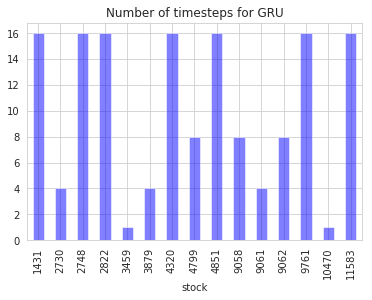

In [11]:
df_best['n_steps'].plot(kind='bar', color=['b'], alpha=0.5)
plt.title('Number of timesteps for GRU')

## Comparision with QUE+LOG

In [12]:
df_best['diff_test_matthews'] = df_best['test_matthews_lstm'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_lstm'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_lstm'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_lstm'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_lstm'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_lstm'] - df_best['roc_auc_log']

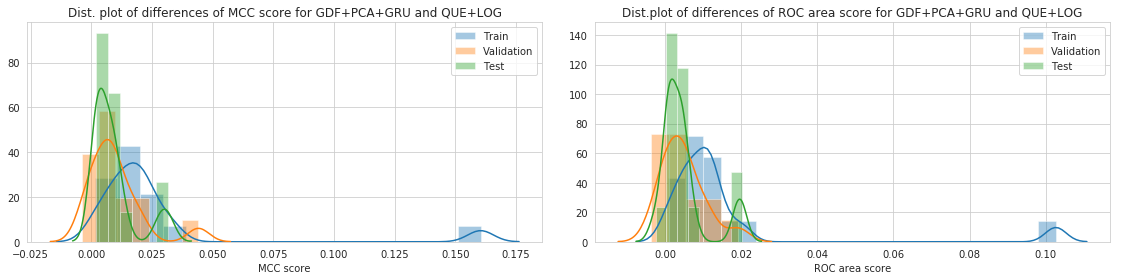

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+GRU and QUE+LOG')
ax1.set_xlabel('MCC score')
ax1.legend()

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+GRU and QUE+LOG')
ax2.set_xlabel('ROC area score')
ax2.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_and_que_log_score_diff.png')

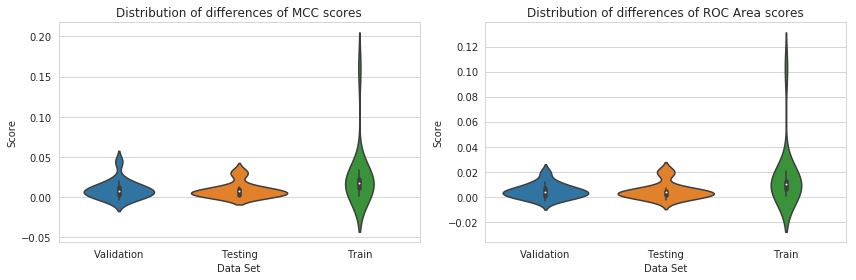

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_and_que_log_violin_score_diff.png')

The table below shows the values for the differences, which distributions are on a plot above.

In [15]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.026035,0.009765,0.008967,0.015448,0.004777,0.004842
std,0.038195,0.011648,0.009267,0.024666,0.005779,0.006444
min,0.001380,-0.003757,0.001739,0.000682,-0.003556,-0.002432
25%,0.011145,0.003053,0.002861,0.006279,0.000417,0.001093
50%,0.018009,0.007519,0.007546,0.009857,0.003981,0.004065
75%,0.022695,0.012672,0.009773,0.012224,0.006804,0.004882
max,0.160418,0.044135,0.031753,0.102657,0.019237,0.020187


In [20]:
print(df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  diff\_train\_matthews &  diff\_matthews &  diff\_test\_matthews &  diff\_train\_roc\_auc &  diff\_roc\_auc &  diff\_test\_roc\_auc \\
\midrule
count &            15.000000 &      15.000000 &           15.000000 &           15.000000 &     15.000000 &          15.000000 \\
mean  &             0.026035 &       0.009765 &            0.008967 &            0.015448 &      0.004777 &           0.004842 \\
std   &             0.038195 &       0.011648 &            0.009267 &            0.024666 &      0.005779 &           0.006444 \\
min   &             0.001380 &      -0.003757 &            0.001739 &            0.000682 &     -0.003556 &          -0.002432 \\
25\%   &             0.011145 &       0.003053 &            0.002861 &            0.006279 &      0.000417 &           0.001093 \\
50\%   &             0.018009 &       0.007519 &            0.007546 &            0.009857 &      0.003981 &           0.004065 \\
75\%   &             0.022695 &    

In [16]:
print('stocks having worse roc area score for LSTM vs LOG on test set')
print(df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']]['stock'].values)
df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']][[
    'roc_auc_lstm', 'roc_auc_log', 'test_roc_auc_lstm', 'test_roc_auc_log', 'r', 's']]

stocks having worse roc area score for LSTM vs LOG on test set
[3459]


,roc_auc_lstm,roc_auc_log,test_roc_auc_lstm,test_roc_auc_log,r,s
stock,,,,,,
3459,0.572673,0.576229,0.579091,0.581522,0.1,0.1


In [17]:
print('stocks having worse MCC score for LSTM vs LOG on test set')
df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']][[
    'matthews_lstm', 'matthews_log', 'test_matthews_lstm', 'test_matthews_log', 'r', 's']]

stocks having worse MCC score for LSTM vs LOG on test set


,matthews_lstm,matthews_log,test_matthews_lstm,test_matthews_log,r,s
stock,,,,,,


In [18]:
df_best[['train_matthews_lstm', 'train_matthews_log',
    'matthews_lstm', 'matthews_log', 'test_matthews_lstm', 'test_matthews_log', 'r', 's']]

,train_matthews_lstm,train_matthews_log,matthews_lstm,matthews_log,test_matthews_lstm,test_matthews_log,r,s
stock,,,,,,,,
1431,0.135360,0.117352,0.129154,0.129605,0.125955,0.123012,0.25,0.25
2730,0.148489,0.132325,0.138500,0.138831,0.163374,0.150420,0.25,0.25
2748,0.266273,0.105855,0.187762,0.143627,0.144817,0.134270,0.01,0.10
2822,0.140367,0.120549,0.128481,0.111054,0.142273,0.110519,0.01,0.10
3459,0.139917,0.129963,0.116439,0.120196,0.133871,0.130774,0.10,0.10
3879,0.156212,0.136157,0.158042,0.137354,0.122292,0.120553,0.01,0.10
4320,0.165328,0.142469,0.148878,0.135224,0.135928,0.133149,0.10,0.10
4799,0.134129,0.111598,0.133453,0.123985,0.131989,0.124435,0.25,0.25
4851,0.179479,0.146122,0.149028,0.141509,0.167083,0.138680,0.01,0.10


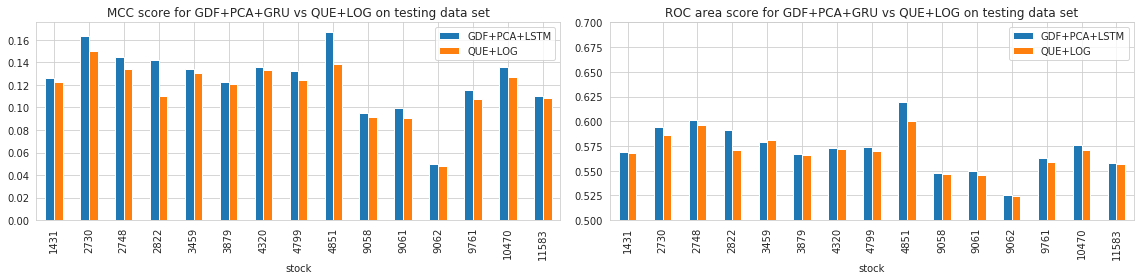

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['test_matthews_lstm', 'test_matthews_log']].plot(kind='bar', ax=ax1)
ax1.legend(['GDF+PCA+LSTM', 'QUE+LOG'])
ax1.set_title('MCC score for GDF+PCA+GRU vs QUE+LOG on testing data set')

df_best[['test_roc_auc_lstm', 'test_roc_auc_log']].plot(kind='bar', ax=ax2)
ax2.legend(['GDF+PCA+LSTM', 'QUE+LOG'])
ax2.set_ylim(0.5, 0.7)
ax2.set_title('ROC area score for GDF+PCA+GRU vs QUE+LOG on testing data set')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_gru_que_log_mcc_roc_scores_bar.png')

## Conclusions

We are using very simple LSTM model. I tried also more complicated ones, but they were overfitting.